In [332]:
# turn data - previous 5 turns
# state data - cumulative turn data
# base data - matchup

# GT - winner

### REGRESSOR 3 - base data

In [333]:
import pandas as pd

display(winners := pd.read_csv('datasets/clean/winners.tsv', header=None, index_col=None, sep='\t').values)

array([[7.500e+01, 1.100e+02, 1.050e+02, ..., 1.063e+03, 1.000e+03,
        1.000e+00],
       [8.500e+01, 6.000e+01, 1.000e+02, ..., 1.591e+03, 1.537e+03,
        0.000e+00],
       [3.500e+01, 5.500e+01, 4.000e+01, ..., 1.569e+03, 1.680e+03,
        0.000e+00],
       ...,
       [7.400e+01, 7.500e+01, 7.000e+01, ..., 1.000e+03, 1.000e+03,
        0.000e+00],
       [2.000e+01, 1.000e+01, 5.500e+01, ..., 1.000e+03, 1.000e+03,
        0.000e+00],
       [6.800e+01, 6.400e+01, 6.000e+01, ..., 1.000e+03, 1.000e+03,
        1.000e+00]])

In [334]:
from sklearn.model_selection import train_test_split

labels = winners[:, -1]
entries = winners[:, :-1]
train_X, test_X, train_y, test_y = train_test_split(entries, labels, test_size=0.3)

In [335]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

lr = Lasso(alpha=0.01).fit(train_X, train_y)
display(lr.score(test_X, test_y))
display(lr.score(train_X, train_y))

testx, testy = list(zip(*sorted(list(zip(test_X, test_y)), key=lambda x: x[1])))
predy = lr.predict(testx)

-0.025608661993866244

0.051785314123714676

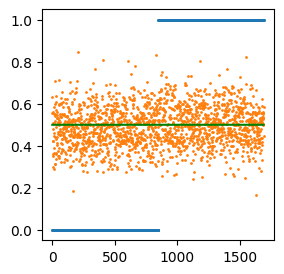

In [161]:
from matplotlib import pyplot as plt

plt.scatter(range(len(testy)), testy, s=1)
plt.scatter(range(len(testy)), predy, s=1)
plt.plot(range(len(testy)), [0.5]*len(testy), c='g')


In [148]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(train_X)


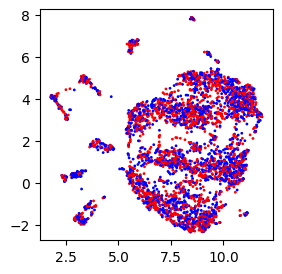

In [149]:
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x)] for x in train_y],
  s=1)
plt.gca().set_aspect('equal', 'datalim')


In [150]:
import sklearn

embedding = sklearn.decomposition.PCA(n_components=2).fit_transform(train_X)


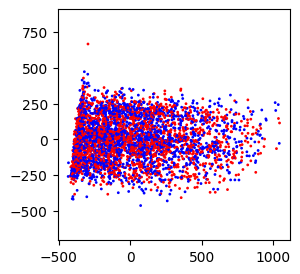

In [151]:
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[['r', 'b'][int(x)] for x in train_y],
  s=1)
plt.gca().set_aspect('equal', 'datalim')

In [167]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

regressor = DecisionTreeClassifier()
regressor.fit(train_X, train_y.astype(int))
regressor.score(test_X, test_y.astype(int))


0.5286812536960378

precision: 0.4994026284348865
recall: 0.4958481613285884
f1: 0.4976190476190477
accuracy: 0.5008870490833827


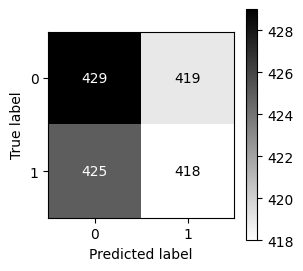

In [168]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

predy = regressor.predict(test_X)
plt.rcParams['figure.figsize'] = [3, 3]

testy = [int(x) for x in testy]
disp = ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(testy, predy))
disp.plot(cmap='binary')
print(f'precision: {precision_score(testy, predy)}')
print(f'recall: {recall_score(testy, predy)}')
print(f'f1: {f1_score(testy, predy)}')
print(f'accuracy: {accuracy_score(testy, predy)}')



### CNN BASED

In [482]:
import json

import numpy as np

ti, tl, tei, tel = [], [], [], []
for SLICESIZE in [5, 10, 15, 20]:
	with open(f'datasets/clean/slices_{SLICESIZE}.json') as fl:
		_data = json.load(fl)

	train_images, train_labels = list(zip(
		*[(np.array(img), label) for img, label in
			zip(_data['train_X'], _data['train_y'])
			if np.array(img).shape == np.array(_data['train_X'][0]).shape]
	))

	test_images, test_labels = list(zip(
		*[(np.array(img), label) for img, label in
			zip(_data['test_X'], _data['test_y'])
			if np.array(img).shape == np.array(_data['test_X'][0]).shape]
	))

	train_labels, test_labels = np.array(train_labels, dtype=int), np.array(test_labels, dtype=int)

	img = np.mean(train_images, axis=0)
	train_images = [x / img.max(axis=0) for x in train_images]
	test_images = [x / img.max(axis=0) for x in test_images]
	train_images, test_images = np.array(train_images), np.array(test_images)

	train_images = train_images.reshape(len(train_labels), SLICESIZE, 38, 1)
	test_images = test_images.reshape(len(test_labels), SLICESIZE, 38, 1)

	ti.append(train_images)
	tl.append(train_labels)
	tei.append(test_images)
	tel.append(test_labels)



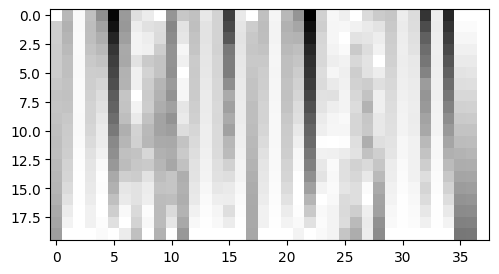

In [483]:
plt.figure(figsize=(10, 3))
all_images = np.concatenate((train_images, test_images), axis=0)
img = np.mean(all_images, axis=0)
plt.grid(False)
plt.imshow(img / img.max(axis=0), cmap='gray')

train_images = [x / img.max(axis=0) for x in train_images]
test_images = [x / img.max(axis=0) for x in test_images]
train_images, test_images = np.array(train_images), np.array(test_images)

In [484]:
from sklearn.metrics import confusion_matrix

def evaluate_classifier(y_true, y_pred):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
  disp.plot(cmap='binary')
  print(f'accuracy: {accuracy_score(np.squeeze(y_true), np.squeeze(y_pred))}')
  print(f'precision: {precision_score(np.squeeze(y_true), np.squeeze(y_pred))}')
  print(f'recall: {recall_score(np.squeeze(y_true), np.squeeze(y_pred))}')
  print(f'f1 score: {f1_score(np.squeeze(y_true), np.squeeze(y_pred))}')


In [485]:
from keras.callbacks import EarlyStopping
from keras import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#### SIZEFIVE MODEL


In [518]:
import tensorflow as tf
models = []
param_filter = [2, 4, 8, 8]
image_shape = [5, 10, 15, 20]

for i in range(0, len(image_shape)):
  train_X, train_y, test_X, test_y = ti[i], tl[i], tei[i], tel[i]
  val = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(64)
  mod = Sequential()
  """
  mod.add(Conv2D(16, (min(param_filter[i]//2, 6), 30), activation='relu', input_shape=(image_shape[i], 38, 1)))
  mod.add(MaxPooling2D((2, 4)))
  mod.add(Conv2D(32*(1 + i//1.5), (2, 2), activation='relu'))
  """
  mod.add(Flatten())
  mod.add(Dense(512, activation='relu'))
  mod.add(Dropout(0.5))
  mod.add(Dense(32, activation='relu'))
  mod.add(Dropout(0.2))
  mod.add(Dense(1, activation='sigmoid'))

  mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=[], run_eagerly=True)

  early_stop = EarlyStopping(monitor='val_loss', patience=3)

  history = mod.fit(train_X, train_y.astype(float), epochs=50, batch_size=128, validation_data=val, callbacks=[early_stop])

  models.append(mod)


Epoch 1/50
174/174 [==============================] - 10s 54ms/step - loss: 0.7619 - val_loss: 0.6915
Epoch 2/50
174/174 [==============================] - 8s 44ms/step - loss: 0.6870 - val_loss: 0.6759
Epoch 3/50
174/174 [==============================] - 7s 43ms/step - loss: 0.6720 - val_loss: 0.6609
Epoch 4/50
174/174 [==============================] - 8s 45ms/step - loss: 0.6609 - val_loss: 0.6563
Epoch 5/50
174/174 [==============================] - 8s 44ms/step - loss: 0.6532 - val_loss: 0.6512
Epoch 6/50
174/174 [==============================] - 7s 42ms/step - loss: 0.6444 - val_loss: 0.6501
Epoch 7/50
174/174 [==============================] - 8s 45ms/step - loss: 0.6378 - val_loss: 0.6458
Epoch 8/50
174/174 [==============================] - 7s 43ms/step - loss: 0.6290 - val_loss: 0.6456
Epoch 9/50
174/174 [==============================] - 8s 44ms/step - loss: 0.6221 - val_loss: 0.6420
Epoch 10/50
174/174 [==============================] - 10s 58ms/step - loss: 0.6132 - val_

296/296 [==============================] - 2s 6ms/step
accuracy: 0.6363636363636364
precision: 0.6380202940567405
recall: 0.6460473893898092
f1 score: 0.6420087518232964
217/217 [==============================] - 2s 8ms/step
accuracy: 0.6656552521311949
precision: 0.593577684073954
recall: 0.6329989622967831
f1 score: 0.6126548376297288
170/170 [==============================] - 1s 6ms/step
accuracy: 0.6757453073242546
precision: 0.6534175334323923
recall: 0.6796754250386399
f1 score: 0.6662878787878788
120/120 [==============================] - 1s 8ms/step
accuracy: 0.7151436031331593
precision: 0.6782231852654388
recall: 0.7158376214979989
f1 score: 0.6965229485396384
120/120 [==============================] - 1s 7ms/step


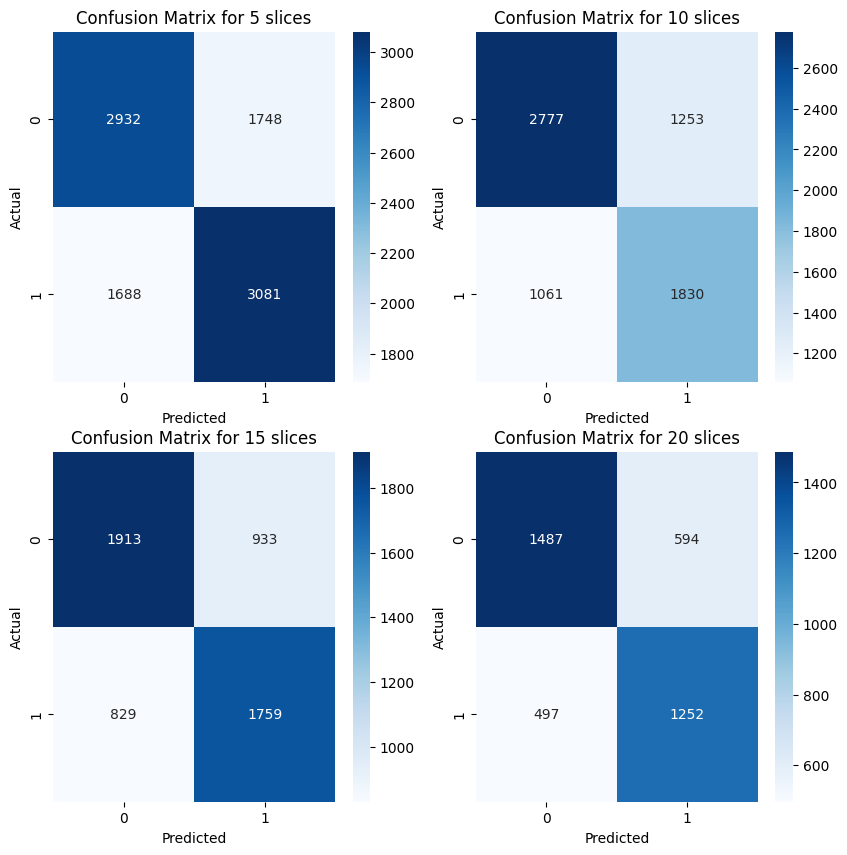

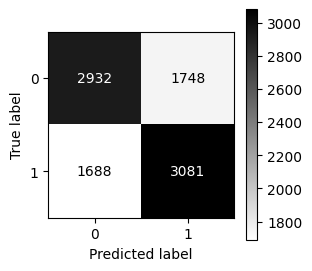

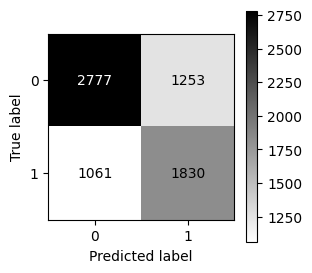

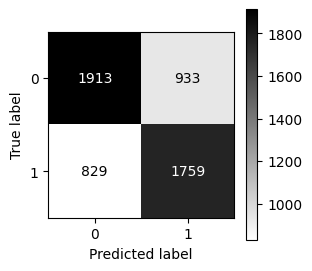

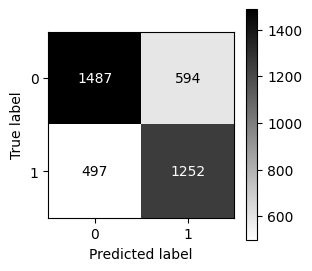

In [519]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(0, len(image_shape)):
  train_X, train_y, test_X, test_y = ti[i], tl[i], tei[i], tel[i]
  evaluate_classifier(test_y.astype(float), np.squeeze(np.round(models[i].predict(test_X))))
  sns.heatmap(confusion_matrix(test_y, np.round(models[i].predict(test_X))), annot=True, fmt='d', cmap='Blues', ax=ax[i // 2][i % 2])
  ax[i // 2][i % 2].set_title(f'Confusion Matrix for {image_shape[i]} slices')
  ax[i // 2][i % 2].set_xlabel('Predicted')
  ax[i // 2][i % 2].set_ylabel('Actual')
